In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error,log_loss
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

from sklearn.inspection import permutation_importance
from sklearn.utils.fixes import parse_version

from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight

from matplotlib.pylab import rcParams
import xgboost as xgb

In [3]:
dogs_train = pd.read_csv('dogs_train.csv')
X_train = dogs_train.drop(['BreedGroupId'], axis = 1)
y_train = dogs_train['BreedGroupId']
feats = X_train.columns

In [4]:
unique, counts = np.unique(y_train, return_counts=True)
unique, counts

(array([0, 1, 2, 3]), array([855, 937, 772, 164]))

In [5]:
sample_weights = compute_sample_weight(class_weight = 'balanced', y = y_train)

In [6]:
unique, counts = np.unique(sample_weights, return_counts = True)
unique, counts

(array([0.72785486, 0.79766082, 0.88341969, 4.15853659]),
 array([937, 855, 772, 164]))

In [7]:
param_dist  = {
              'n_estimators': [400, 450, 500],
              'max_depth' : [8, 9],
              'learning_rate' :[0.1, 0.2, 0.3]
             }

In [8]:
model = GradientBoostingClassifier()
cv = GridSearchCV(model, param_dist, cv = 5)

cv.fit(X_train, y_train, sample_weight = sample_weights)
print("Tuned Parameters: {}".format(cv.best_params_))
print("Best score is {}".format(cv.best_score_))

Tuned Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500}
Best score is 0.3445831232987196


In [54]:
best = cv.best_params_
classmodel = GradientBoostingClassifier(learning_rate = best["learning_rate"], max_depth = best["max_depth"], n_estimators = best["n_estimators"])
classmodel.fit(X_train, y_train, sample_weight = sample_weights)

GradientBoostingClassifier(learning_rate=0.2, max_depth=8, n_estimators=450)

In [55]:
print("Train score =",classmodel.score(X_train, y_train))

Train score = 0.9633431085043989


In [56]:
confusion_matrix(y_train,classmodel.predict(X_train))

array([[821,  11,  15,   8],
       [ 17, 891,  19,  10],
       [  3,   8, 752,   9],
       [  0,   0,   0, 164]])

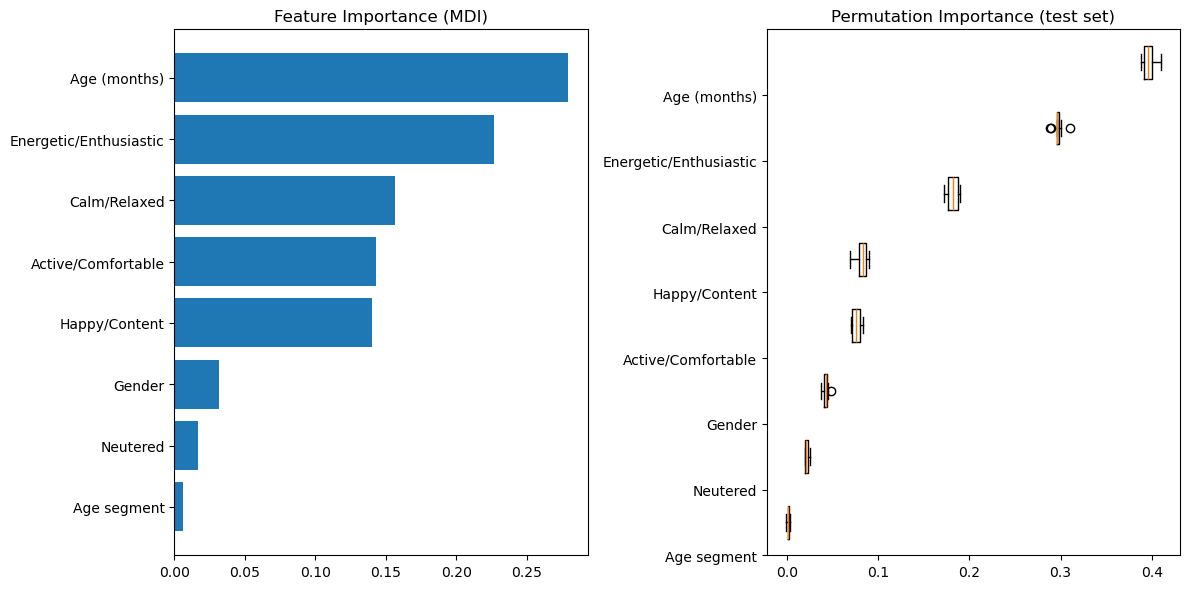

In [57]:
feature_importance = classmodel.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(len(sorted_idx)) + 0.5
fig = plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align = "center")
plt.yticks(pos, np.array(feats)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(classmodel, X_train, y_train, n_repeats = 10, random_state = 42, n_jobs = 2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)

plt.boxplot(result.importances[sorted_idx].T, vert = False)
plt.yticks(pos, np.array(feats)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [40]:
data_dmatrix = xgb.DMatrix(data = X_train, label = y_train)
sample_weights = compute_sample_weight(class_weight = 'balanced', y = y_train)

In [41]:
param_dist  = {
              'objective':['binary:logistic'],
              'n_estimators': [30, 100, 200],
              'max_depth' : [2,3,4, 5],
              'learning_rate' :[0.01, 0.1, 1],
              'alpha':[5, 10, 20],    #L1 reg.  lambda is L2
             }

In [42]:
model=xgb.XGBClassifier()
cv = GridSearchCV(model, param_dist, cv=5)

cv.fit(X_train, y_train, sample_weight=sample_weights)
print("Tuned Parameters: {}".format(cv.best_params_))
print("Best score is {}".format(cv.best_score_))

Tuned Parameters: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'objective': 'binary:logistic'}
Best score is 0.940243976207279


In [1]:
params = {
            'objective':'binary:logistic',
            'max_depth': 3,
            'alpha': 5,
            'learning_rate': 0.1,
            'n_estimators':30
        }           
            
            
xgb_clf = xgb.XGBClassifier(**params, booster='gbtree')
xgb_clf.fit(X_train, y_train, sample_weight=sample_weights)

NameError: name 'xgb' is not defined

In [ ]:
result=xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=100, early_stopping_rounds=10, metrics="auc",as_pandas=True)
print(result)